# Analyse BlueSeis BSPF Events

With pressure sensor parascientific and new sensor 

In [10]:
import os 
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# from andbro__savefig import __savefig
from obspy.clients.fdsn import Client

## Configurations

In [11]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [15]:
config = {}

config['minlatitude'] = 31 #-1
config['maxlatitude'] = 35 #+1
config['minlongitude'] = -119 #-1
config['maxlongitude'] = -114 #+1

config['BSPF_lon'] = np.array([-116.455439])
config['BSPF_lat'] = np.array([33.610643])

config['minmagnitude'] = 2.5

config['tbeg'] = obs.UTCDateTime("2022-10-01")
config['tend'] = obs.UTCDateTime("2023-03-31")

config['eventfile'] = "BSPF_event_catalog"

config['trigger'] = data_path+"/BSPF/trigger/"

config['outpath'] = data_path+"/BSPF/data/"

In [16]:
def __export_new_events(config, events_old, events):
    
    ## combine new and old catalog
    tmp = pd.concat([__cat_to_df(events_old), __cat_to_df(events)]).reset_index(drop=False)
    ## remove duplicates
    df = tmp.drop_duplicates(subset=['index'], keep=False)
    ## sort and set index
    df = df.sort_index(ascending=False)
    df.set_index('index', inplace=True, drop=True)
    
    ## export new events to pickle file
    print(f" -> export new events: {config['outpath']}new_events.pkl")
    df.to_pickle(config['outpath']+"new_events.pkl")
    
    del tmp, df  

In [17]:
def __cat_to_df(cat):
    
    from pandas import DataFrame
    
    times = []
    lats = []
    lons = []
    deps = []
    magnitudes = []
    magnitudestype = []
    
    for event in cat:
        if len(event.origins) != 0 and len(event.magnitudes) != 0:
            times.append(event.origins[0].time.datetime)
            lats.append(event.origins[0].latitude)
            lons.append(event.origins[0].longitude)
            deps.append(event.origins[0].depth)
            magnitudes.append(event.magnitudes[0].mag)
            magnitudestype.append(event.magnitudes[0].magnitude_type )
            
    df = DataFrame({'latitude':lats,'longitude':lons,'depth':deps,
                    'magnitude':magnitudes,'type':magnitudestype}, 
                     index = times
                  )
    
    return df

In [18]:
def __add_distances_and_backazimuth(config, df):

    from obspy.geodetics.base import gps2dist_azimuth

    dist = np.zeros(len(df))
    baz = np.zeros(len(df))

    
    for ii, ev in enumerate(df.index):
        try:
            dist[ii], az, baz[ii] = gps2dist_azimuth(config['BSPF_lat'], config['BSPF_lon'],
                                                     df.latitude[ii], df.longitude[ii],
                                                     a=6378137.0, f=0.0033528106647474805
                                                     )
        except:
            print(" -> failed to compute!")
            
    df['backazimuth'] = baz
    df['distances_km'] = dist/1000

    return df

## Get Events

In [19]:
client = Client("USGS")

## events - all in area and time period
events_all = client.get_events(minlatitude=config['minlatitude'], maxlatitude=config['maxlatitude'],
                               minlongitude=config['minlongitude'], maxlongitude=config['maxlongitude'],
                               starttime=config['tbeg'],
                               endtime=config['tend'],
                               )

# ## events smaller than 2.0
# events_1 = client.get_events(minlatitude=config['minlatitude'], maxlatitude=config['maxlatitude'],
#                              minlongitude=config['minlongitude'], maxlongitude=config['maxlongitude'],
#                              starttime=config['tbeg'],
#                              endtime=config['tend'],
#                              maxmagnitude=2.0,
#                             )

## events between 2.0 and 3.0 within distance 0.5 degrees
events_2 = client.get_events(
                             latitude=config['BSPF_lat'], longitude=config['BSPF_lon'],
                             starttime=config['tbeg'],
                             endtime=config['tend'],
                             minmagnitude=2.0,
                             maxmagnitude=3.0,
                             maxradius=0.5,
                            )

## events between 2.0 and 3.0 within distance 2.0 degrees
events_3 = client.get_events(
                             latitude=config['BSPF_lat'], longitude=config['BSPF_lon'],
                             starttime=config['tbeg'],
                             endtime=config['tend'],
                             minmagnitude=3.0,
                             maxmagnitude=5.0,
                             maxradius=5.0,
                            )

## events larger than 5.0 
events_4 = events_all.filter("magnitude > 5.0")


## join specified event catalogs together
events = events_2 + events_3 + events_4


# events.plot(projection="local");

events.write(config['outpath']+config['eventfile']+".xml", format="QUAKEML")
events_all.write(config['outpath']+config['eventfile']+"_all.xml", format="QUAKEML")

/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/obspy/io/quakeml/core.py:1109: UserWarning: 'quakeml:earthquake.usgs.gov/fdsnws/event/1/query?starttime=2023-04-03T00%3A00%3A00.000000&endtime=2023-04-17T00%3A00%3A00.000000&minlatitude=30.0&maxlatitude=36.0&minlongitude=-120.0&maxlongitude=-113.0' is not a valid QuakeML URI. It will be in the final file but note that the file will not be a valid QuakeML file.
  warnings.warn(msg % obj.id)


In [20]:
## convert catalog object to data frame
events_df = __cat_to_df(events)
events_all_df = __cat_to_df(events_all)

## add epicentral distances
__add_distances_and_backazimuth(config, events_df)
__add_distances_and_backazimuth(config, events_all_df)

## write data frame as pickle file
events_df.to_pickle(config['outpath']+config['eventfile']+".pkl")
events_all_df.to_pickle(config['outpath']+config['eventfile']+"_all.pkl")

## Plot Event Timeline

In [21]:
events_all_df = events_all_df.rename_axis('timestamp').reset_index()
events_all_df['seconds'] = [abs((events_all_df.timestamp.min()-tt).total_seconds()) for tt in events_all_df.timestamp]

events_df = events_df.rename_axis('timestamp').reset_index()
events_df['seconds'] = [abs((events_df.timestamp.min()-tt).total_seconds()) for tt in events_df.timestamp]
events_df

,timestamp,latitude,longitude,depth,magnitude,type,backazimuth,distances_km,seconds
0,2023-04-13 15:10:49.030,33.756500,-115.917833,3660.0,2.08,ml,252.169243,52.409346,876921.030
1,2023-04-13 00:52:21.540,33.373500,-116.884000,13370.0,2.64,ml,56.440315,47.728002,825413.540
2,2023-04-11 11:45:48.980,33.200167,-116.166333,5540.0,2.07,ml,329.508159,52.876578,691820.980
3,2023-04-10 14:51:00.950,33.479667,-116.494833,13700.0,2.72,ml,14.125299,14.980779,616532.950
4,2023-04-10 14:50:54.400,33.486167,-116.493833,12720.0,2.11,ml,14.470659,14.259219,616526.400
5,2023-04-07 03:55:25.600,33.226667,-116.086333,10900.0,2.11,ml,321.228834,54.701525,317997.600
6,2023-04-05 14:02:33.330,33.584500,-116.827500,13520.0,2.35,ml,85.097484,34.655519,181625.330
7,2023-04-16 15:23:27.389,38.142900,-117.970400,7400.0,3.30,ml,164.332532,521.137325,1136879.389
8,2023-04-14 14:56:56.320,32.521500,-115.625500,15530.0,3.52,mlr,327.540549,143.516359,962488.320
9,2023-04-12 02:22:35.250,36.565000,-121.155500,3660.0,3.26,ml,126.035769,539.437081,744427.250


In [30]:
events_all_df[events_all_df.distances_km < 15]

,timestamp,latitude,longitude,depth,magnitude,type,backazimuth,distances_km,seconds
24,2023-04-15 21:50:17.550,33.482167,-116.483500,13690.0,0.51,ml,10.356345,14.486199,1111240.88
26,2023-04-15 21:46:23.970,33.490833,-116.470500,13120.0,0.71,ml,6.004370,13.362015,1111007.30
27,2023-04-15 21:26:09.000,33.496667,-116.473500,14680.0,0.76,ml,7.552646,12.752386,1109792.33
42,2023-04-15 08:10:51.970,33.490333,-116.449167,12060.0,1.04,ml,357.502226,13.356773,1062075.30
43,2023-04-15 05:54:33.720,33.480667,-116.451667,13360.0,0.74,ml,358.608895,14.420475,1053897.05
48,2023-04-14 22:56:50.900,33.483833,-116.452833,12980.0,0.79,ml,359.015009,14.067083,1028834.23
74,2023-04-13 19:33:08.990,33.492833,-116.451333,13380.0,0.76,ml,358.329734,13.072344,930212.32
75,2023-04-13 19:33:03.770,33.488833,-116.455167,12230.0,0.84,ml,359.892831,13.510459,930207.10
90,2023-04-13 02:59:48.010,33.486000,-116.476333,14840.0,0.92,ml,7.984227,13.960206,870611.34
94,2023-04-13 00:12:00.720,33.484500,-116.472000,13620.0,1.24,ml,6.268807,14.075341,860544.05


## Plots

In [24]:
def __plot_timeline(catalog_df, catalog_all_df):

    fig, ax = plt.subplots(1, 1, figsize=(15,5))

    cax = ax.scatter(catalog_df.timestamp, catalog_df.distances_km, s=4**catalog_df.magnitude, 
                     c=catalog_df.magnitude, alpha=0.6, cmap='viridis')

    ax.scatter(catalog_all_df.timestamp, catalog_all_df.distances_km, s=4**catalog_all_df.magnitude, c='grey', alpha=0.5, zorder=-1)

    plt.colorbar(cax, ax=ax, pad=0.01)

    ax.set_ylim(bottom=0)
    ax.set_ylabel("Distance (km)", fontsize=14)

    ax.grid(ls=":", zorder=-1)
    
#     ax.set_xlim(events_all_df.timestamp.min().date(), events_all_df.timestamp.max().date())
#     ax.set_xlim(obs.UTCDateTime("2022-09-29"), obs.UTCDateTime("2023-04-03"))

    ax.set_title(f"triggered={len(catalog_df)}")
    
    plt.show();
    return fig

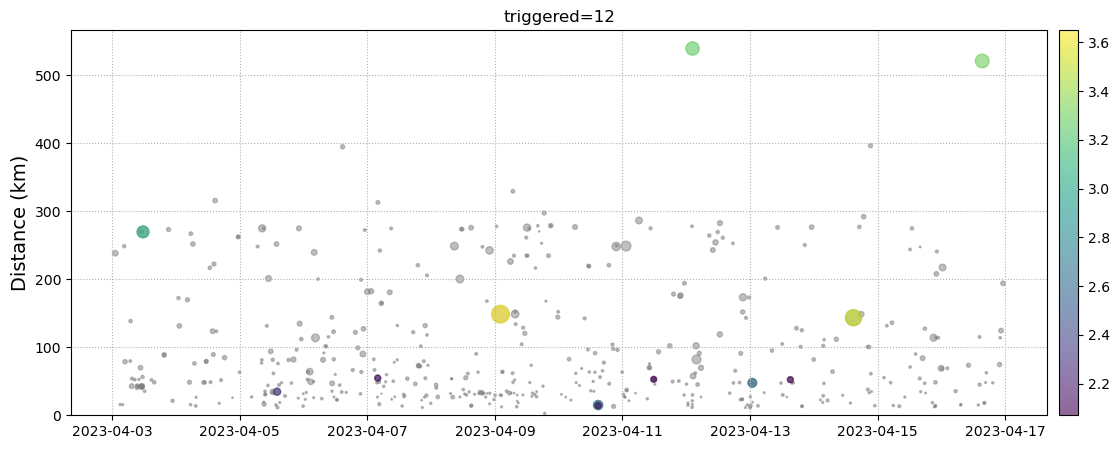

In [25]:
fig = __plot_timeline(events_df, events_all_df)

## Plot on Map

In [ ]:
# def __makeplot_eventmap(config, data1, data2):
    

#     import pygmt
#     import pandas as pd

    
#     # Set the region
#     region = [config['minlongitude'], config['maxlongitude'], config['minlatitude'], config['maxlatitude']]

#     resolution = "30s"

#     fig = pygmt.Figure()
    
# #     fig.basemap(region=region, projection="M15c", frame=True)


#     # make color pallets
#     cmap = pygmt.makecpt(cmap='etopo1', series='-7999/5000/1000', continuous=True)
    
#     ## define etopo data file
#     topo_data = pygmt.datasets.load_earth_relief(resolution=resolution, region=region)
    
#     ## adjust land and sea/lakes
# #     land = topo_data * pygmt.grdlandmask(region=region, 
# #                                          spacing=resolution, 
# #                                          maskvalues=[0, 1], 
# #                                          resolution="f"
# #                                         )
#     wet = topo_data * pygmt.grdlandmask(region=region, 
#                                         spacing=resolution, 
#                                         maskvalues=[1, "NaN"], 
#                                         resolution="f"
#                                        )
    
#     ##plot high res topography
#     fig.grdimage(
#         grid=topo_data,
#         region=region,
#         projection='M5i',
#         shading=True,
#         cmap = cmap,
#         frame=True,
#         nan_transparent=True
#     )     


# #     cmap_wet = pygmt.makecpt(cmap='etopo1', series='-7999/5000/1000', continuous=True)

#     fig.grdimage(
#         grid=wet,
#         region=region,
#         projection='M5i',
#         shading=True,
#         cmap='seafloor',
#         frame=True,
#         nan_transparent=True
#     )
    
    
#     cmap = pygmt.makecpt(cmap='etopo1', series='-8000/5000/1000', continuous=True)    
#     fig.colorbar(cmap=cmap, position="g-118.8/31.45+w3c/0.3c+h", box="+gwhite+c0.1+r", 
#                  frame=["x+lElevation", r"y+l(km)"], scale=0.001)    


#     ## add coastlines
#     fig.coast(shorelines=True, borders="1/0.4p,black,solid", frame=False)
# #     fig.coast(rivers="1/0.5p,blue") # Rivers

    
#     ## colorbar colormap
#     cmap_mag = pygmt.makecpt(cmap="viridis", series=[data1.magnitude.min(), data1.magnitude.max()])
# #     cmap_mag = pygmt.makecpt(cmap="viridis", series=[data1.timestamp.astype(str)[0], data1.timestamp.astype(str)[len(data1)-1]])
#     cmap_mag = pygmt.makecpt(cmap="viridis", series=[data1.seconds.min(), data1.seconds.max()])

# #     cmap_depth = pygmt.makecpt(cmap="rainbow", series=[data1.depth.min()/1000, data1.depth.max()/1000])
    
# #     ## plot data coordinates
#     fig.plot(
#         x=data2.longitude,
#         y=data2.latitude,
#         size=0.04*2**data2.magnitude,
#         fill='grey',
#         style="cc",
#         pen="0p,black",
#     )    

#     fig.plot(
#         x=data1.longitude,
#         y=data1.latitude,
#         size=0.04
#         *2**data1.magnitude,
# #         fill=data1.depth/1000,
#         fill=data1.seconds,
#         cmap=True,
#         style="cc",
#         pen="0.1p,black",
#         transparency=50,        
#     )    

#     ## plot PFO
#     fig.plot(
#         x=config['BSPF_lon'],
#         y=config['BSPF_lat'],
#         size=np.array([0.3]),
#         fill="red",
#         style="t0.5c",
#         pen="black",
#     )
    
#     fig.text(
#         text="PFO",
#         x=config['BSPF_lon'],
#         y=config['BSPF_lat'],
#         offset=[0.35],
#         font="9p,Helvetica-Bold,black"
#     )
    

#     ## add depth colorbar
# #     fig.colorbar(frame='af+l"Depth (km)"', cmap=cmap_depth)
#     fig.colorbar(frame='af+l"Days"', cmap=cmap_mag, position="JMR+o-2c/3c+w5c/0.5c+n+mc", scale=1/86400)
    
#     ## save figure to file
#     fig.savefig(config['outpath']+'tmp_event_map.png')

#     fig.show();
#     return fig

In [ ]:
# fig = __makeplot_eventmap(config, events_df, events_all_df)

## Plot Triggered Catalog

In [ ]:
# def __read_pickle(config, path, filename):
    
#     import pickle

#     with open(path+filename, 'rb') as f:
#         triggerfile = pickle.load(f)
        
#     return triggerfile

In [ ]:
# trigger_events = __read_pickle(config, config['trigger'], "trigger_all.pkl")

In [ ]:
# def __find_matches(trigger_events, catalog):

#     trigger_times, cosum = [], []
#     for trig in trigger_events:
#         trigger_times.append(trig['time'])
#         cosum.append(trig['coincidence_sum'])

    
#     matches, time_diffs, events_triggered, idxs = [], [], [], []

#     ## extract origin times from catalog
#     event_times = [catalog.events[j].origins[0].time for j in range(len(catalog))]
    
    
#     for trigger_time in trigger_times:

#         ## compute time differences in seconds
#         diff = [event_time-trigger_time for event_time in event_times]
        
#         ## only the ones before the trigger in time
#         abs_diff = [abs(d) for d in diff if d < 0]
        
#         ## get closest event
#         t_min, t_idx = min(abs_diff), diff.index(-min(abs_diff))
                
#         time_diffs.append(t_min)
#         matches.append(trigger_time)
#         events_triggered.append(event_times[t_idx])
#         idxs.append(t_idx)
        
#     cat_sel = [catalog.events[idx] for idx in idxs]
        
        
#     t_days = [(match-obs.UTCDateTime("2022-10-01"))/86400 for match in matches]
#     plt.figure(figsize=(15,5))
#     for tt, dd, cosum in zip(t_days, time_diffs, cosum):
#         if cosum == 4:
#             plt.scatter(tt, dd, zorder=2, color='red', s=10)
#         if cosum == 5:
#             plt.scatter(tt, dd, zorder=2, color='orange', s=10)
#         if cosum == 6:
#             plt.scatter(tt, dd, zorder=2, color='green', s=10)
            
#     plt.yscale("log")
#     plt.grid(which="both", zorder=-1, ls=":")
#     plt.ylabel("Time Differences (s)")
#     plt.xlabel("Time (days)")
#     plt.xlim(0, 190)
    
#     return np.array(matches), np.array(events_triggered), cat_sel

In [ ]:
# matches, events_triggered, cat_select = __find_matches(trigger_events, events_all)

In [ ]:
# cat_select_df = __cat_to_df(cat_select)

# __add_distances_and_backazimuth(config, cat_select_df)

# cat_select_df = cat_select_df.rename_axis('timestamp').reset_index()
# cat_select_df['seconds'] = [abs((cat_select_df.timestamp.min()-tt).total_seconds()) for tt in cat_select_df.timestamp]

### Plots

In [ ]:
# fig = __plot_timeline(cat_select_df, events_all_df)

In [ ]:
# fig.savefig("timeline_triggered.png")

In [ ]:
# fig = __makeplot_eventmap(config, cat_select_df, events_all_df)

In [ ]:
# fig.savefig("map_triggered.png")